# Notebook containing the necessary scripts to correct systematic trends in the APOGEE abundances with surface gravity

The idea here is very simple. We take every APOGEE abundance (w.r.t. H) and plot that as a function of log$g$. We then compute the differences and add that to the initial [X/H] abundance to correct for systematic trends. In order to mitigate this and to not remove any stellar evolutionary trends, we perform this on only a small log$g$ range (in this case 1 < log$g$ < 2)

In [1]:
# load in the necessary modules
import numpy as np
from astropy.io import fits
import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
path = '/Users/dhortadarrington/Documents/Master/data/DR17_McMillan_astroNN.fits'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# load the mask for the sample we want to correct the abundances on 
loadpath =  '/Users/dhortadarrington/Documents/Projects/accreted-systems/sav/paper/'
mask = np.load(loadpath+'mask_parentsamp.npy')

In [4]:
# save the abundances as arrays (this is silly memory wise but already wrote the code like this and was too lazy to change it)

fehs = data.field('FE_H')
mgfe = data.field('MG_FE')
snr = data.field('SNR')
alfe = data.field('AL_FE')
kfe = data.field('K_FE')
alfe_err = data.field('AL_FE_ERR')
nafe = data.field('NA_FE')
fehs_err = data.field('FE_H_ERR')
nife = data.field('NI_FE')
cfe = data.field('C_FE')
nfe = data.field('N_FE')
sfe = data.field('S_FE')
cefe = data.field('CE_FE')
tife = data.field('TI_FE')
sife = data.field('SI_FE')
kfe = data.field('K_FE')
ofe = data.field('O_FE')
pfe = data.field('P_FE')
cafe = data.field('CA_FE')
mnfe = data.field('MN_FE')
cife = data.field('CI_FE')
cofe = data.field('CO_FE')
crfe = data.field('CR_FE')
vfe = data.field('V_FE')
cufe = data.field('CU_FE')
tife = data.field('TI_FE')
apo_id = data.field('APOGEE_ID')
pname = data.field('PROGRAMNAME')
logg = data.field('LOGG')
teff = data.field('TEFF')
fehs_err = data.field('FE_H_ERR')
mgfe_err = data.field('MG_FE_ERR')

In [5]:
# get the abundances as a function of H not Fe
ch = cfe + fehs
nh = nfe + fehs
oh = ofe + fehs
nah = nafe + fehs
mgh = mgfe + fehs
sih = sife + fehs
sh = sfe + fehs
kh = kfe + fehs
cah = cafe + fehs
tih = tife + fehs
vh = vfe + fehs
crh = crfe + fehs
mnh = mnfe + fehs
coh = cofe + fehs
nih = nife + fehs
ceh = cefe + fehs
alh = alfe + fehs

# equation taken from Weinberg et al 2022
cnh = np.log10(10**(ch+8.39) + 10**(nh+7.78)) - np.log10(10.**8.39 + 10.**7.78)

In [6]:
abundances2 = np.array([ch,nh,oh,nah,mgh,alh,sih,sh,kh,cah,tih,vh,crh,mnh,fehs,coh,nih,ceh,cnh])
print(len(abundances2))
cnh_err = np.sqrt(data['C_FE_ERR']**2+data['N_FE_ERR']**2)

abundances_err2 = np.array([data['C_FE_ERR'],data['N_FE_ERR'],data['O_FE_ERR'],\
                           data['NA_FE_ERR'],data['MG_FE_ERR'],\
                           data['Al_FE_ERR'],data['SI_FE_ERR'],data['S_FE_ERR'],\
                           data['K_FE_ERR'],data['CA_FE_ERR'],data['TI_FE_ERR'],data['V_FE_ERR'],\
                            data['CR_FE_ERR'],data['MN_FE_ERR'],data['FE_H_ERR'],data['CO_FE_ERR'],\
                            data['NI_FE_ERR'],data['CE_FE_ERR'],cnh_err])

19


# Now correct the abundances for the full parent sample


0it [00:00, ?it/s]

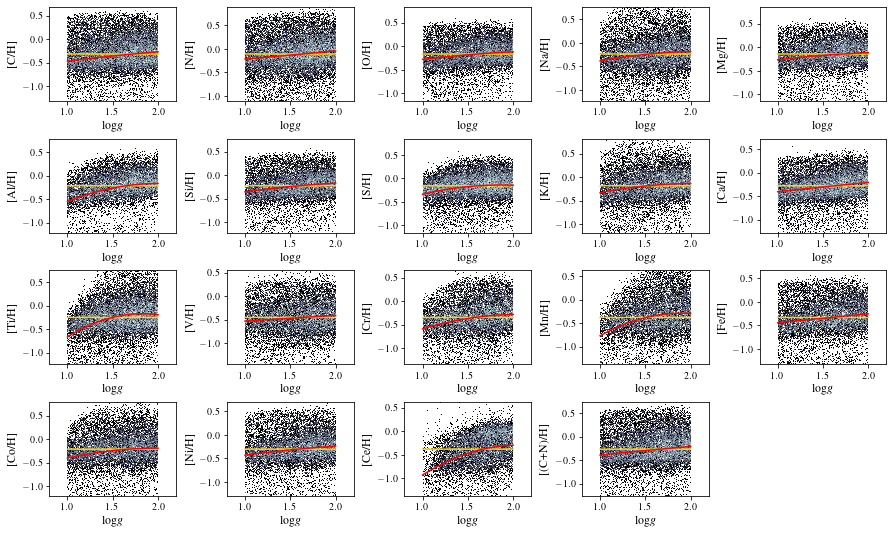

In [7]:
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm
fig = plt.figure(constrained_layout=True,figsize=(15,9))
gs = grid.GridSpec(4,5)
p = 0

abundances_list = ['[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Al/H]','[Si/H]','[S/H]','[K/H]',\
               '[Ca/H]','[Ti/H]','[V/H]','[Cr/H]','[Mn/H]','[Fe/H]','[Co/H]','[Ni/H]','[Ce/H]', '[(C+N)/H]']   

diff_logg_parent = []

# loop through every abundance and plot the distribution, overall median and line of best fit (2nd degree order polynomial)     
for indx, i in tqdm.tqdm_notebook(enumerate(abundances2)):
    # create a mask to remove the -9999 in abundances and x parameter (i.e., teff or logg)    
    mask_999 = (i>-10)&(logg>-10)
    good_abun = i[mask&mask_999&(logg<2.)&(logg>1.)]
    good_logg = logg[mask&mask_999&(logg<2.)&(logg>1.)]

    if len(good_abun) > 0:
        
        # fit the second order polynomial and get the overall median
        fit_logg = np.polyfit(good_logg,good_abun,2)
        exis = np.linspace(np.min(good_logg),np.max(good_logg),len(good_logg))
        fit_abun = fit_logg[0]*exis**2 + fit_logg[1]*exis + fit_logg[2]
        # fit_abun = fit_logg[0]*exis + fit_logg[1]
        median = np.tile(np.median(good_abun),len(good_abun))
        diff_logg_parent.append(median - fit_abun)
        
        ax = fig.add_subplot(gs[p])
#         ax.scatter(good_logg,good_abun,s=0.1,c='k')
        ax.hist2d(good_logg,good_abun,bins=250,cmap='bone',norm=LogNorm())
        ax.plot(exis,median,color='gold')
        ax.plot(exis,fit_abun,color='r')
        ax.set_xlim(0.8,2.2)
        ax.set_ylim(np.median(good_abun)-1,np.median(good_abun)+1)
        ax.set_ylabel(str(abundances_list[indx]),fontsize=12)
        ax.set_xlabel(r'log$g$',fontsize=12)
        p+=1
    
    else:
        diff_logg.append(median - fit_abun)
        ax = fig.add_subplot(gs[p])
        ax.text(1.3,0,'No data')
        ax.set_xlim(0.8,2.2)
        ax.set_ylim(-0.25,0.25)
        ax.set_ylabel(str(abundances_list[indx]),fontsize=12)
        ax.set_xlabel(r'log$g$',fontsize=12)
        p+=1
gs.update(wspace=0.4,hspace=0.4)
    

In [8]:
def find_median_trend(xs, ys,bins=8):

    x_edges = np.linspace(np.min(xs),np.max(xs),bins)
    delta_xs = (x_edges[2]-x_edges[1])/2
    medians = np.zeros((bins))
    medians_xs = np.zeros((bins))

    for indx, i in enumerate(x_edges[:-1]):
        mask_bins = (xs>i)&(i+delta_xs>xs)
        medians[indx] = np.nanmedian(ys[mask_bins])
        medians_xs[indx] = np.nanmedian(xs[mask_bins])
        
    xss = np.linspace(np.min(xs),np.max(xs),bins)
    fit_ys = np.polyfit(xss[:-1],medians[:-1],2)
    exis = np.linspace(np.min(xs),np.max(xs),len(xs))
    fit_medians = fit_ys[0]*exis**2 + fit_ys[1]*exis + fit_ys[2]
    return fit_medians, medians, medians_xs,exis


0it [00:00, ?it/s]

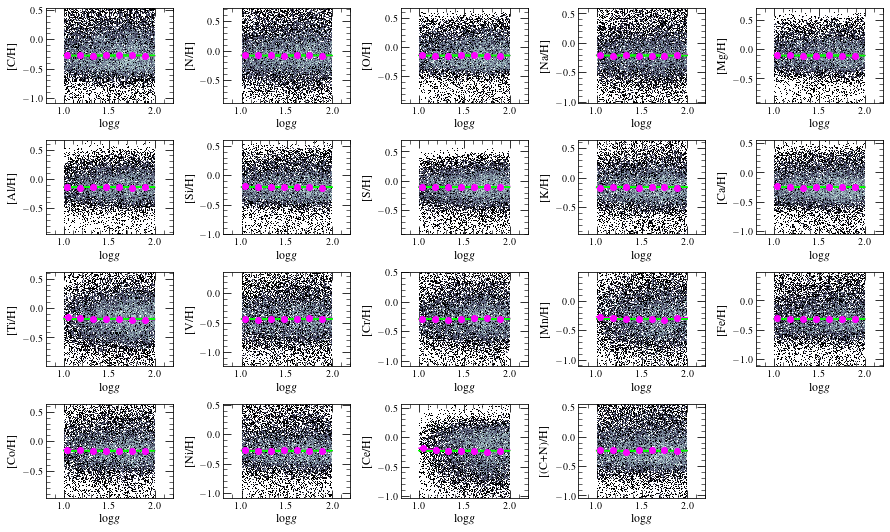

In [9]:
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm
fig = plt.figure(constrained_layout=True,figsize=(15,9))
gs = grid.GridSpec(4,5)
p = 0
    
abundances_list = ['[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Al/H]','[Si/H]','[S/H]','[K/H]',\
               '[Ca/H]','[Ti/H]','[V/H]','[Cr/H]','[Mn/H]','[Fe/H]','[Co/H]','[Ni/H]','[Ce/H]','[(C+N)/H]']  

corr_abun_parent = []
corr_ids_parent = []
number_ids_parent = []
sorted_number_ids_parent = []
good_logg_sorted_parent = []
save_abun_err_parent = []
save_fehs_parent = []
save_fehs_err_parent = []


# loop through every abundance and plot the distribution, overall median and line of best fit (2nd degree order polynomial)     
for indx, i in tqdm.tqdm_notebook(enumerate(abundances2)):
    # create a random array of numbers to store the ids to then recover later     
    rand_num_ids = np.linspace(0,len(i),len(i))
    number_ids_parent.append(rand_num_ids)
    
    # create a mask to remove the -9999 in abundances and x parameter (i.e., teff or logg)    
    mask_999 = (i>-10)&(logg>-10)
    good_abun = i[mask&mask_999&(logg<2.)&(logg>1.)]
    good_logg = logg[mask&mask_999&(logg<2.)&(logg>1.)]
    good_ids = apo_id[mask&mask_999&(logg<2.)&(logg>1.)]
    good_rand_num_ids = rand_num_ids[mask&mask_999&(logg<2.)&(logg>1.)]
    good_abun_err_parent = abundances_err2[indx][mask&mask_999&(logg<2.)&(logg>1.)]
    good_fehs = fehs[mask&mask_999&(logg<2.)&(logg>1.)]
    good_fehs_err = data['FE_H_ERR'][mask&mask_999&(logg<2.)&(logg>1.)]
    
    if len(good_abun) > 0:
        
        # sort out the order
        order_abun = np.argsort(good_logg)
        good_abun_sorted = good_abun[order_abun]
        good_ids_sorted = good_ids[order_abun]
        good_number_sorted = good_rand_num_ids[order_abun]
        sorted_abun_err_parent = good_abun_err_parent[order_abun]
        sorted_fehs_parent = good_fehs[order_abun]
        sorted_fehs_err_parent = good_fehs_err[order_abun]
        
        good_logg_sorted_parent.append(good_logg)
        # get the corrected abundances
        corr_abun = good_abun_sorted + diff_logg_parent[indx]
        
        corr_abun_parent.append(corr_abun)
        corr_ids_parent.append(good_ids_sorted)
        sorted_number_ids_parent.append(good_number_sorted)
        save_abun_err_parent.append(sorted_abun_err_parent)
        save_fehs_parent.append(sorted_fehs_parent)
        save_fehs_err_parent.append(sorted_fehs_err_parent)
        
        median_corr_abun = np.tile(np.median(corr_abun),len(good_logg))
        
        fit_corr, medians_corr, medians_logg_corr , exis_corr = find_median_trend(good_logg,corr_abun)

        ax = fig.add_subplot(gs[p])
        ax.hist2d(good_logg,corr_abun,bins=250,cmap='bone',norm=LogNorm())
        ax.plot(exis_corr,fit_corr,c='magenta')
        ax.plot(good_logg,median_corr_abun,c='lime')
        ax.errorbar(medians_logg_corr[:-1],medians_corr[:-1],color='magenta',fmt='o')
        ax.set_xlim(0.8,2.2)
        ax.set_ylim(np.median(corr_abun)-0.8,np.median(corr_abun)+0.8)
        ax.set_xlabel(r'log$g$',fontsize=12)
        ax.set_ylabel(str(abundances_list[indx]),fontsize=12)
        ax.tick_params(which='major',labelsize=10,direction='in',top=True,right=True,length=8)
        ax.tick_params(which='minor', length=4, direction='in',top=True,right=True)
        ax.minorticks_on()
        p+=1
    
    else:
        ax = fig.add_subplot(gs[p])
        ax.text(1.3,0,'No data')
        ax.set_xlim(0.8,2.2)
        ax.set_ylim(-0.15,0.15)
        ax.set_xlabel(r'log$g$',fontsize=12)
        ax.set_ylabel(str(abundances_list[indx]),fontsize=12)
        p+=1
gs.update(wspace=0.4,hspace=0.4)
    

In [10]:
# transform these X/H abundances back to X/Fe and then use those as the corrected abundances

abundances_corr_parent_xfe = []

for indx, i in enumerate(corr_abun_parent):
    
    # define corrected feh 
    corr_feh = corr_abun_parent[14]

    # define the mask to get the same stars to then conver X/H to X/Fe
    mask_match =  np.isin(sorted_number_ids_parent[14],sorted_number_ids_parent[indx])

    corr_abun_xfe = i - corr_feh[mask_match]
    
    abundances_corr_parent_xfe.append(corr_abun_xfe)
    

0it [00:00, ?it/s]

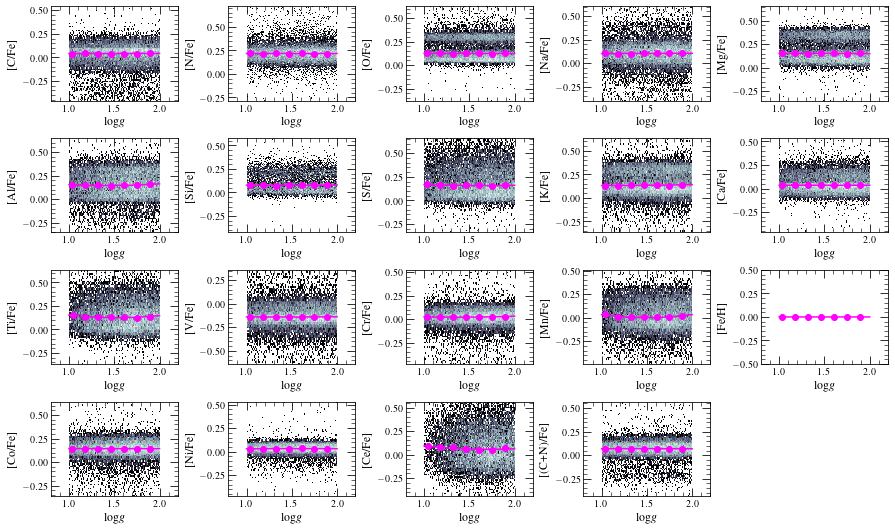

In [11]:
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm
fig = plt.figure(constrained_layout=True,figsize=(15,9))
gs = grid.GridSpec(4,5)
p = 0
    
abundances_list = ['[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[S/Fe]','[K/Fe]',\
               '[Ca/Fe]','[Ti/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Ce/Fe]','[(C+N)/Fe]'] 

# loop through every abundance and plot the distribution, overall median and line of best fit (2nd degree order polynomial)     
for indx, i in tqdm.tqdm_notebook(enumerate(abundances_corr_parent_xfe)):
    
    fit_corr_xfe_parent, medians_corr_xfe_parent, medians_logg_corr_xfe_parent , exis_corr_xfe_parent\
                = find_median_trend(good_logg_sorted_parent[indx],i)

    ax = fig.add_subplot(gs[p])
    ax.hist2d(good_logg_sorted_parent[indx],i,bins=250,cmap='bone',norm=LogNorm())
    ax.plot(exis_corr_xfe_parent,fit_corr_xfe_parent,c='magenta')
#     ax.plot(good_logg_sorted_lowa_aleph,medians_corr_corr_xfe,c='lime')
    ax.errorbar(medians_logg_corr_xfe_parent[:-1],medians_corr_xfe_parent[:-1],color='magenta',fmt='o')
    ax.set_xlim(0.8,2.2)
    ax.set_ylim(np.median(i)-0.5,np.median(i)+0.5)
    ax.set_xlabel(r'log$g$',fontsize=12)
    ax.set_ylabel(str(abundances_list[indx]),fontsize=12)
    ax.tick_params(which='major',labelsize=10,direction='in',top=True,right=True,length=8)
    ax.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    ax.minorticks_on()
    p+=1

gs.update(wspace=0.4,hspace=0.4)
    